In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings
import time

from scipy.stats.kde import gaussian_kde
from numpy import linspace

import h5py as h5 


In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [13]:
hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_merger_rates/hobbs_2e7_combined.h5'
mm_pathData        = os.environ['SCRATCH'] + f"/supernova_remnant_merger_rates/mm20_2e7_combined.h5"

In [14]:
fdata = h5.File(hobbs_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


In [15]:
fdata = h5.File(mm_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


# Investigate properties of mergers

To get the eccentricity-period distribution of BNSs, we set dco_type='bns' above, and will select the set of DCOs from the H5 file whose Merges_Hubble_Time==True, Stellar_Type(1)'+ 'Stellar_Type(2)==26.

In [16]:
def mask_type(data, st_type1, st_type2, dco_type='BNS', merge=None):
    masked_data = data
    
    if merge is not None:
        mask_hubble = (merge==True)
        masked_data = masked_data[mask_hubble]
        st_type1 = st_type1[mask_hubble]
        st_type2 = st_type2[mask_hubble]
        
    if dco_type=='BBH':
        st_type_sum = 28
    if dco_type=='BNS':
        st_type_sum = 26
    if dco_type=='BHNS':
        st_type_sum = 27
    if dco_type=='all':
        return masked_data
    
    mask = (st_type1 + st_type2==st_type_sum)
    return masked_data[mask]

In [17]:
# sma in AU
# m1 in M_sun 
# m2 in M_sun
# period in yr

def sma_to_period(sma, m1, m2):
    sma = sma*u.au
    m1 = m1*const.M_sun
    m2 = m2*const.M_sun
    
    return 2*np.pi*np.sqrt((sma**3)/(const.G*(m1+m2))).to(u.yr).value

In [18]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_merge = hobbs_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

hobbs_m1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
hobbs_m2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

hobbs_type1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
hobbs_type2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

hobbs_ecc_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
hobbs_dco_seed = hobbs_fdata['BSE_Double_Compact_Objects']["SEED"][()]

hobbs_unbound_ALL = hobbs_fdata['BSE_Supernovae']["Unbound"][()]
hobbs_kicks_ALL = hobbs_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
hobbs_sn_stellartype = hobbs_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
hobbs_sn_orbital_v = hobbs_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]
hobbs_sn_seed = hobbs_fdata['BSE_Supernovae']["SEED"][()]

hobbs_fdata.close()

In [19]:
mm_fdata = h5.File(mm_pathData, 'r')
mm_merge = mm_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

mm_m1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
mm_m2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

mm_type1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
mm_type2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

mm_ecc_ALL = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma_ALL = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_dco_seed = mm_fdata['BSE_Double_Compact_Objects']["SEED"][()]

mm_unbound_ALL = mm_fdata['BSE_Supernovae']["Unbound"][()]
mm_kicks_ALL = mm_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
mm_sn_stellartype = mm_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
mm_sn_orbital_v = mm_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]
mm_sn_seed = mm_fdata['BSE_Supernovae']["SEED"][()]

mm_fdata.close()


## See the period distribution of unbound objects

In [20]:
hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

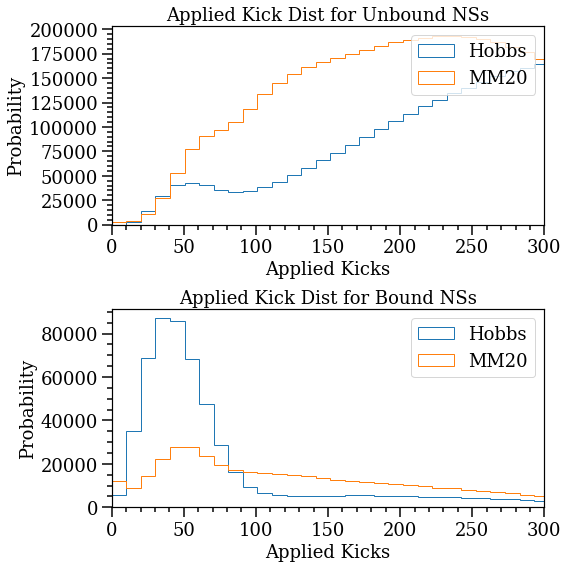

In [23]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kicks',\
           nameY='Probability')

layoutAxes(ax=ax2, nameX='Applied Kicks',\
           nameY='Probability')


bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_ns_kicks, bins=bins, histtype='step', label="Hobbs")
ax1.hist(mm_unbound_ns_kicks, bins=bins, histtype='step',  label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Applied Kick Dist for Unbound NSs", fontsize=fm)
ax1.set_xlim(0, 300)

ax2.hist(hobbs_bound_ns_kicks, bins=bins, histtype='step', label="Hobbs")
ax2.hist(mm_bound_ns_kicks, bins=bins, histtype='step',  label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Applied Kick Dist for Bound NSs", fontsize=fm)
ax2.set_xlim(0, 300)
plt.tight_layout()
plt.show()

In [24]:
hobbs_unbound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

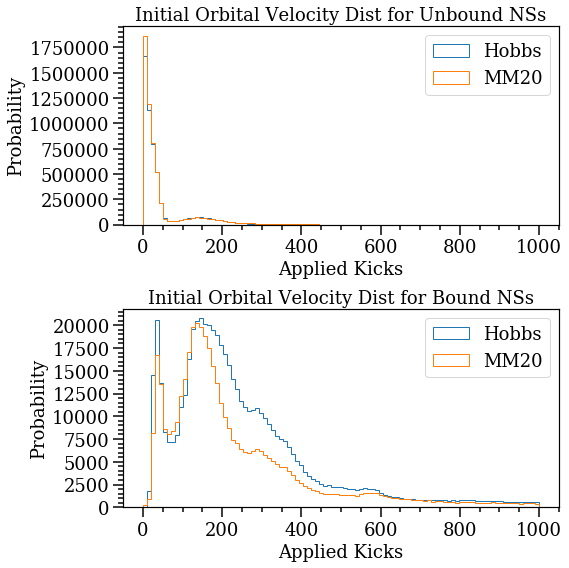

In [25]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kicks',\
           nameY='Probability')
layoutAxes(ax=ax2, nameX='Applied Kicks',\
           nameY='Probability')

bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_orbital_v, bins=bins, histtype='step', label="Hobbs")
ax1.hist(mm_unbound_orbital_v, bins=bins, histtype='step',  label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Orbital Velocity Dist for Unbound NSs", fontsize=fm)

ax2.hist(hobbs_bound_orbital_v, bins=bins, histtype='step', label="Hobbs")
ax2.hist(mm_bound_orbital_v, bins=bins, histtype='step',  label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Initial Orbital Velocity Dist for Bound NSs", fontsize=fm)

plt.tight_layout()
plt.show()

## What percentage of Supernovae keep (future) BNS systems intact in the two cases?

In [26]:
mm_future_bns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BNS', merge=mm_merge)
print(mm_future_bns_seeds_dco)
print(len(mm_future_bns_seeds_dco))

mm_future_bns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bns_seeds_dco)
mm_future_bns_seeds_sn = mm_sn_seed[mm_future_bns_seeds_sn_mask]

print(mm_future_bns_seeds_sn)
print(len(mm_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18667016 18681776 18689693 ... 24646600 24654812 24673454]
2014
[18667016 18667016 18681776 ... 24654812 24673454 24673454]
4028


In [27]:
hobbs_future_bns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BNS', merge=hobbs_merge)
print(hobbs_future_bns_seeds_dco)
print(len(hobbs_future_bns_seeds_dco))

hobbs_future_bns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bns_seeds_dco)
hobbs_future_bns_seeds_sn = hobbs_sn_seed[hobbs_future_bns_seeds_sn_mask]

print(hobbs_future_bns_seeds_sn)
print(len(hobbs_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18665943 18667016 18674379 ... 24673454 24680667 24684340]
3344
[18665943 18665943 18667016 ... 24680667 24684340 24684340]
6688


In [28]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask]

mm_bns_percentage = (len(mm_kicks_bns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask]

hobbs_bns_percentage = (len(hobbs_kicks_bns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS")


0.05% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS


## What percentage of Supernovae keep (future) BHNS systems intact in the two cases?

In [29]:
mm_future_bhns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BHNS', merge=mm_merge)
print(mm_future_bhns_seeds_dco)
print(len(mm_future_bhns_seeds_dco))

mm_future_bhns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bhns_seeds_dco)
mm_future_bhns_seeds_sn = mm_sn_seed[mm_future_bhns_seeds_sn_mask]

print(mm_future_bhns_seeds_sn)
print(len(mm_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18661387 18662094 18662992 ... 24681463 24682191 24685182]
11061
[18661387 18661387 18662094 ... 24682191 24685182 24685182]
22122


In [30]:
hobbs_future_bhns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BHNS', merge=hobbs_merge)
print(hobbs_future_bhns_seeds_dco)
print(len(hobbs_future_bhns_seeds_dco))

hobbs_future_bhns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bhns_seeds_dco)
hobbs_future_bhns_seeds_sn = hobbs_sn_seed[hobbs_future_bhns_seeds_sn_mask]

print(hobbs_future_bhns_seeds_sn)
print(len(hobbs_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18661287 18665543 18666364 ... 24671380 24673753 24680230]
6622
[18661287 18661287 18665543 ... 24673753 24680230 24680230]
13244


In [31]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bhns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask]

mm_bhns_percentage = (len(mm_kicks_bhns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bhns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bhns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask]

hobbs_bhns_percentage = (len(hobbs_kicks_bhns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bhns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS")


0.14% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS


I don't get it. Why should the number of BNS and BHNS systems left intact by Hobbs be the same? Shouldn't more BHNS systems survive due to higher required kicks to disrupt?

# Period-Eccentricity Distribution

In [32]:
dco_type='BHNS'
# dco_type='BNS'

In [33]:
hobbs_ecc = mask_type(hobbs_ecc_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_sma = mask_type(hobbs_sma_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m1 = mask_type(hobbs_m1_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m2 = mask_type(hobbs_m2_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

print(len(hobbs_ecc))

hobbs_period = sma_to_period(hobbs_sma, hobbs_m1, hobbs_m2)
print((hobbs_period))

6622
[0.0011286  0.00202565 0.00167708 ... 0.00221799 0.0009781  0.00090037]


In [ ]:
mm_ecc = mask_type(mm_ecc_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_sma = mask_type(mm_sma_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m1 = mask_type(mm_m1_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m2 = mask_type(mm_m2_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

print(len(mm_ecc))

mm_period = sma_to_period(mm_sma, mm_m1, mm_m2)
# print((mm_period))

In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)

lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.semilogy()
plt.ylim(1e-3, 1e-1)
# plt.xlim(0.4, 0.6)
plt.grid()
plt.show()


In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Period [yr]')

plt.scatter(hobbs_ecc, hobbs_period, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_period, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.loglog()
# plt.semilogy()
plt.ylim(-1e-5, 1e-2)
plt.grid()
plt.show()